# **Replication of Empirical Results**: Nickell Bias in Panel Local Projection: Financial Crises Are Worse Than You Think
**Date**: September 17, 2025

This document aims to replicate the empirical results of Section 3 (**Figures 4, 5, 6, and 7**) in this paper, with the entire analysis performed in R. This paper highlights the presence of the Nickell bias in the panel local projection (LP) with fixed-effects (FE) estimation and proposes the split-panel jackknife (SPJ) estimator as a simple and effective solution to eliminate the bias and restore valid statistical inference.

Our primary task is to revisit four influential empirical studies on the macroeconomic consequences of financial crises: 
- **Romer and Romer (2017)** (RR)
- **Baron, Verner, and Xiong (2021)** (BVX)
- **Mian, Sufi, and Verner (2017)** (MSV)
- **Cerra and Saxena (2008)** (CS)

In [ ]:
# Set the working directory if necessary

# Load libraries
library(ggplot2)
library(reshape2)
library(ggpubr)

Warning message:
"package 'ggplot2' was built under R version 4.5.2"
Warning message:
"package 'reshape2' was built under R version 4.5.2"
Warning message:
"package 'ggpubr' was built under R version 4.5.2"


## 1. Romer and Romer (2017)

This script replicates **Figure 4**. The analysis uses the dataset from the RR's official replication package.

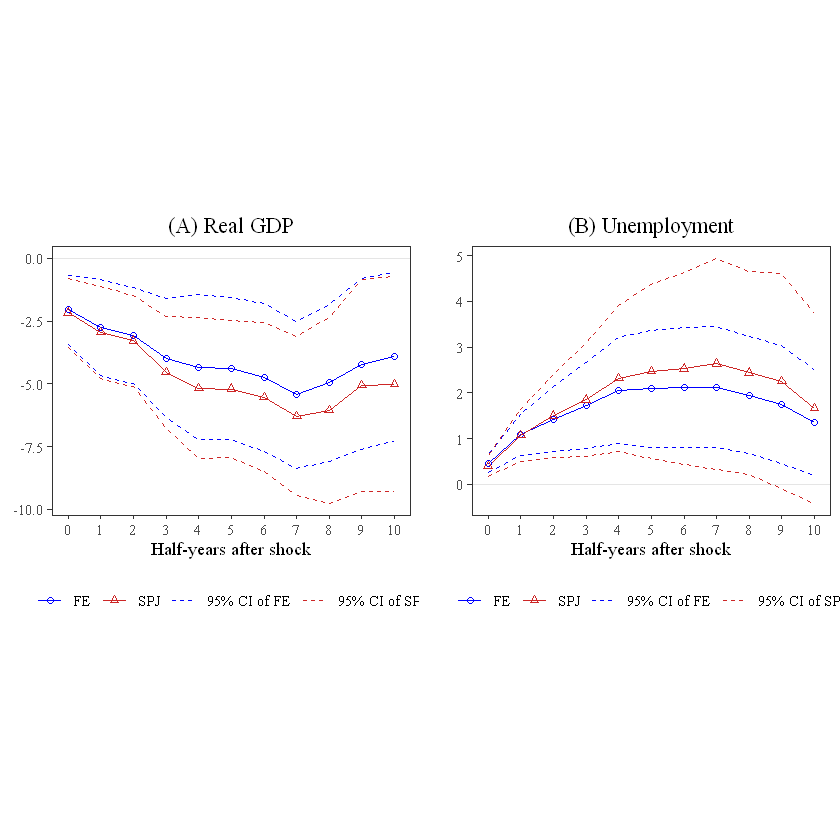

In [2]:
# =====================================================================
# 1. SETUP
# =====================================================================

# Clearing
rm(list=ls())
# This file is expected to define the function `LP_panel()`.
source("LP_panel_all.r")



# ><><><><><><><><><><><><><><><>< GDP ><><><><><><><><><><><><><><><><

# =====================================================================
# 2. DATA, MODEL SPECIFICATION, AND ESTIMATION
# =====================================================================

# Load the dataset.
data <- read.csv("empirical_RR_f4_lngdp_1980.csv")


# Define the shock variable.
X.name = c("CRISIS")
# Define the control variables.
c.name = c("l1LNGDP",	"l2LNGDP",	"l3LNGDP",	"l4LNGDP", "l1CRISIS",	"l2CRISIS",	"l3CRISIS",	"l4CRISIS")
# Define the outcome variables for each horizon.
Y.names <- c("f0LNGDP",	"f1LNGDP",	"f2LNGDP",	"f3LNGDP",	"f4LNGDP",	"f5LNGDP",	"f6LNGDP",	"f7LNGDP",	"f8LNGDP",	"f9LNGDP",	"f10LNGDP")


# Create empty matrices to store results for IRF and se.
IRF.FE <- rbind(matrix(NA,length(Y.names),length(X.name)))
se.FE <- rbind(matrix(NA,length(Y.names),length(X.name)))
IRF.jackknife <- rbind(matrix(NA,length(Y.names),length(X.name)))
se.jackknife <- rbind(matrix(NA,length(Y.names),length(X.name)))

# Loop through each outcome variable (horizon).
for (iname in 1:length(Y.names)){
  Y.name <- Y.names[iname]

  # Run FE estimation.
  fit.FE <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                     c.name = c.name,
                     lagY = 0, H=0, 
                     method = "FE",
                     te = T,
                     two_way_cluster = F,
                     robust = F,
                     eigens = F)
  # Store the FE results.
  IRF.FE[iname,] <-  fit.FE$IRF
  se.FE[iname,] <-  fit.FE$se
  
  # Run SPJ estimation.
  fit.jackknife <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                            c.name = c.name,
                            lagY = 0, H=0, 
                            method = "SPJ",
                            te = T,
                            two_way_cluster = F,
                            robust = F,
                            eigens = F)
  # Store the SPJ results.
  IRF.jackknife[iname,] <-  fit.jackknife$IRF
  se.jackknife[iname,] <-  fit.jackknife$se
}

# Calculate 95% confidence intervals for FE results.
low <- IRF.FE  - 1.96*se.FE 
high <- IRF.FE  + 1.96*se.FE 
plot.mat.FE <- cbind(low,IRF.FE,high)
# Calculate 95% confidence intervals for SPJ results.
low = IRF.jackknife - 1.96*se.jackknife
high = IRF.jackknife + 1.96*se.jackknife
plot.mat.jackknife <- cbind(low,IRF.jackknife,high)

# =====================================================================
# 3. PLOTTING
# =====================================================================

# Combine all results into a single data frame for plotting.
H = length(Y.names)-1
j_data = data.frame(cbind(0:H,7*plot.mat.FE[,c(2,1,3)],7*plot.mat.jackknife[,c(2,1,3)])) # multiply the coefficients by 7 (same as RR)
colnames(j_data) <- c("h","fe","fe_l","fe_u","jackknife","jackknife_u","jackknife_l")
j_data <- melt(j_data,id="h")
fjg = substr(j_data$variable, 1, 2)
gr=c(rep("fe",11),rep("fc",22),rep("ja",11),rep("jc",22))
j_data <- cbind(j_data,fjg,gr)

# Plot with ggplot2.
f4gdp = ggplot(j_data, aes(x=h, y=value, group=variable, color=gr, linetype=gr, shape=gr)) +
  geom_line() +
  geom_hline(aes(yintercept=0), colour="1", linetype="solid",alpha = 0.1) +
  scale_color_manual(values=c("blue","firebrick3", "blue","firebrick3"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  scale_linetype_manual(values=c("solid","solid","dashed","dashed"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  geom_point()+
  scale_shape_manual(values = c(21,24,NA,NA),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ"))+
  guides(color=guide_legend('title'),linetype=guide_legend('title'),shape=guide_legend('title'))+
  scale_x_continuous(breaks=j_data$h, labels = j_data$h) +
  labs(x = "Half-years after shock", y = NULL, title = "(A) Real GDP") +
  theme_bw() +
  theme(panel.grid=element_blank()) +
  theme(aspect.ratio=3/4,
        text=element_text(family="serif"),
        plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom")



# ><><><><><><><><><><><><><>< unemployment ><><><><><><><><><><><><><><

# =====================================================================
# 2. DATA, MODEL SPECIFICATION, AND ESTIMATION
# =====================================================================

# Load the dataset.
data <- read.csv("empirical_RR_f4_lnunemp_1980.csv")

# Define the shock variable.
X.name = c("CRISIS")
# Define the control variables.
c.name = c("l1UNEMP","l2UNEMP",	"l3UNEMP",	"l4UNEMP", "l1CRISIS",	"l2CRISIS",	"l3CRISIS",	"l4CRISIS")
# Define the outcome variables for each horizon.
Y.names <- c("f0UNEMP",	"f1UNEMP",	"f2UNEMP",	"f3UNEMP",	"f4UNEMP",	"f5UNEMP",	"f6UNEMP",	"f7UNEMP",	"f8UNEMP",	"f9UNEMP",	"f10UNEMP")

# Create empty matrices to store results for IRF and se.
IRF.FE <- rbind(matrix(NA,length(Y.names),length(X.name)))
se.FE <- rbind(matrix(NA,length(Y.names),length(X.name)))
IRF.jackknife <- rbind(matrix(NA,length(Y.names),length(X.name)))
se.jackknife <- rbind(matrix(NA,length(Y.names),length(X.name)))

# Loop through each outcome variable (horizon).
for (iname in 1:length(Y.names)){
  Y.name <- Y.names[iname]

  # Run FE estimation.
  fit.FE <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                     c.name = c.name,
                     lagY = 0, H=0, 
                     method = "FE",
                     te = T,
                     two_way_cluster = F,
                     robust = F,
                     eigens = F)
  # Store the FE results.
  IRF.FE[iname,] <-  fit.FE$IRF
  se.FE[iname,] <-  fit.FE$se
  
  # Run SPJ estimation.
  fit.jackknife <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                            c.name = c.name,
                            lagY = 0, H=0, 
                            method = "SPJ",
                            te = T,
                            two_way_cluster = F,
                            robust = F,
                            eigens = F)
  # Store the SPJ results.
  IRF.jackknife[iname,] <-  fit.jackknife$IRF
  se.jackknife[iname,] <-  fit.jackknife$se
}

# Calculate 95% confidence intervals for FE results.
low <- IRF.FE  - 1.96*se.FE 
high <- IRF.FE  + 1.96*se.FE 
plot.mat.FE <- cbind(low,IRF.FE,high)
# Calculate 95% confidence intervals for SPJ results.
low = IRF.jackknife - 1.96*se.jackknife
high = IRF.jackknife + 1.96*se.jackknife
plot.mat.jackknife <- cbind(low,IRF.jackknife,high)

# =====================================================================
# 3. PLOTTING
# =====================================================================

# Combine all results into a single data frame for plotting.
H = length(Y.names)-1
j_data = data.frame(cbind(0:H,7*plot.mat.FE[,c(2,1,3)],7*plot.mat.jackknife[,c(2,1,3)])) # multiply the coefficients by 7 (same as RR)
colnames(j_data) <- c("h","fe","fe_l","fe_u","jackknife","jackknife_u","jackknife_l")
j_data <- melt(j_data,id="h")
fjg = substr(j_data$variable, 1, 2)
gr=c(rep("fe",11),rep("fc",22),rep("ja",11),rep("jc",22))
j_data <- cbind(j_data,fjg,gr)

# Plot with ggplot2.
f4unemp = ggplot(j_data, aes(x=h, y=value, group=variable, color=gr, linetype=gr, shape=gr)) +
  geom_line() +
  geom_hline(aes(yintercept=0), colour="1", linetype="solid",alpha = 0.1) +
  scale_color_manual(values=c("blue","firebrick3", "blue","firebrick3"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  scale_linetype_manual(values=c("solid","solid","dashed","dashed"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  geom_point()+
  scale_shape_manual(values = c(21,24,NA,NA),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ"))+
  guides(color=guide_legend('title'),linetype=guide_legend('title'),shape=guide_legend('title'))+
  scale_x_continuous(breaks=j_data$h, labels = j_data$h) +
  labs(x = "Half-years after shock", y = NULL, title = "(B) Unemployment") +
  theme_bw() +
  theme(panel.grid=element_blank()) +
  theme(aspect.ratio=3/4,
        text=element_text(family="serif"),
        plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom")



# =====================================================================
# 4. EXPORTING THE FIGURE
# =====================================================================

# Combine the two plots into one figure and save it as a PDF.
all = suppressWarnings(ggarrange(f4gdp,f4unemp, ncol=2,nrow=1, align = "hv"))
ggsave("RR_f4.pdf", all, width = 8, height = 4, units = 'in', dpi = 1200)
# Display the combined figure.
all

## 2. Baron, Verner, and Xiong (2021)

This script replicates **Figure 5**. The analysis uses the dataset from the BVX's official replication package.

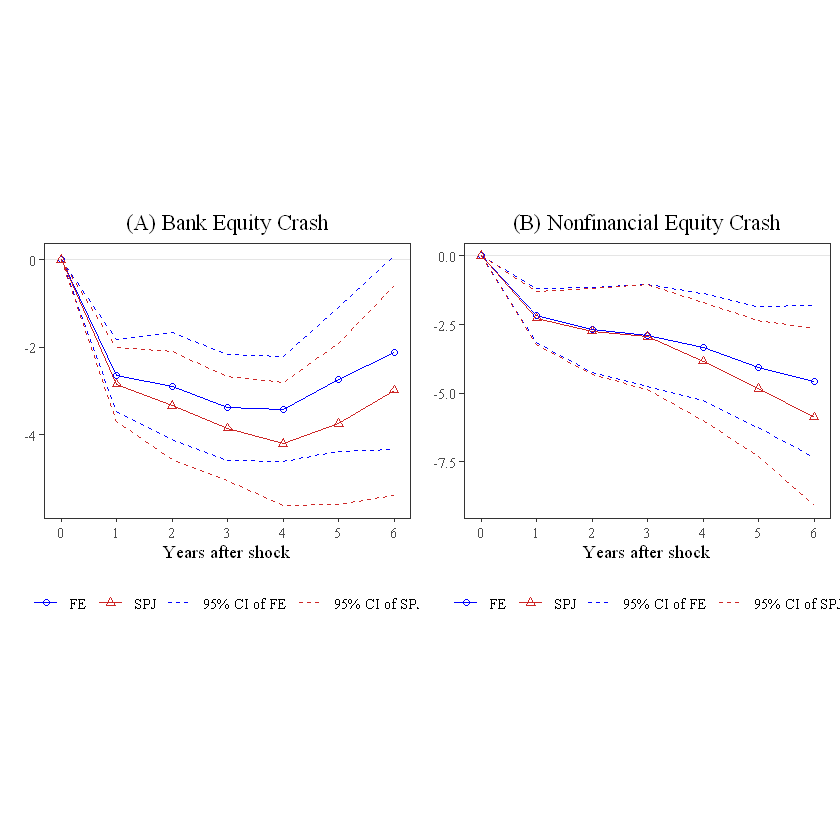

In [4]:
# =====================================================================
# 1. SETUP
# =====================================================================

# Clearing
rm(list=ls())
# This file is expected to define the function `LP_panel()`.
source("LP_panel_all.r")

# =====================================================================
# 2. DATA, MODEL SPECIFICATION, AND ESTIMATION
# =====================================================================

# Load the dataset.
data <- read.csv("empirical_BVX_t1_y.csv")


# Define the shock variable.
X.name = c("R_B","R_N")
# Define the control variables.
c.name = c("L1R_B","L2R_B","L3R_B",
           "L1R_N","L2R_N","L3R_N",
           "D1y","L1D1y","L2D1y","L3D1y",
           "D1d_y","L1D1d_y","L2D1d_y","L3D1d_y")
# Define the outcome variables for each horizon.
Y.names <- c("Fd1y","Fd2y","Fd3y","Fd4y","Fd5y","Fd6y")


# Create empty matrices to store results for IRF and se.
IRF.FE <- rbind(0,matrix(NA,length(Y.names),2))
se.FE <- rbind(0,matrix(NA,length(Y.names),2))
IRF.jackknife <- rbind(0,matrix(NA,length(Y.names),2))
se.jackknife <- rbind(0,matrix(NA,length(Y.names),2))

# Loop through each outcome variable (horizon).
for (iname in 1:length(Y.names)){
  Y.name <- Y.names[iname]
  data[,Y.name]=100*data[,Y.name]
  
  # Run FE estimation.
  fit.FE <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                     c.name = c.name,
                     lagY = 0, H=0, 
                     method = "FE",
                     te = F,
                     two_way_cluster = T,
                     robust = T,
                     eigens = T)
  # Store the FE results.
  IRF.FE[iname+1,] <-  fit.FE$IRF
  se.FE[iname+1,] <-  fit.FE$se
  
  # Run SPJ estimation.
  fit.jackknife <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                            c.name = c.name,
                            lagY = 0, H=0, 
                            method = "SPJ",
                            te = F,
                            two_way_cluster = T,
                            robust = T,
                            eigens = T)
  # Store the SPJ results.
  IRF.jackknife[iname+1,] <-  fit.jackknife$IRF
  se.jackknife[iname+1,] <-  fit.jackknife$se
}

# Calculate 95% confidence intervals for FE results.
low <- IRF.FE  - 1.96*se.FE 
high <- IRF.FE  + 1.96*se.FE 
plot.mat.FE <- cbind(low,IRF.FE,high)
plot.mat.FE[1,] <- 0 # No estimation required when h=0
# Calculate 95% confidence intervals for SPJ results.
low = IRF.jackknife - 1.96*se.jackknife
high = IRF.jackknife + 1.96*se.jackknife
plot.mat.jackknife <- cbind(low,IRF.jackknife,high)
plot.mat.jackknife[1,] <- 0 # No estimation required when h=0

# =====================================================================
# 3. PLOTTING
# =====================================================================

#R_B
# Combine all results into a single data frame for plotting.
H = length(Y.names)
j_data = data.frame(cbind(0:H,plot.mat.FE[,c(3,1,5)],plot.mat.jackknife[,c(3,1,5)]))
colnames(j_data) <- c("h","fe","fe_l","fe_u","jackknife","jackknife_u","jackknife_l")
j_data <- melt(j_data,id="h")
fjg = substr(j_data$variable, 1, 2)
gr=c(rep("fe",7),rep("fc",14),rep("ja",7),rep("jc",14))
j_data <- cbind(j_data,fjg,gr)

# Plot with ggplot2.
yb = ggplot(j_data, aes(x=h, y=value, group=variable, color=gr, linetype=gr, shape=gr)) +
  geom_line() +
  geom_hline(aes(yintercept=0), colour="1", linetype="solid",alpha = 0.1) +
  scale_color_manual(values=c("blue","firebrick3", "blue","firebrick3"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  scale_linetype_manual(values=c("solid","solid","dashed","dashed"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  geom_point()+
  scale_shape_manual(values = c(21,24,NA,NA),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ"))+
  guides(color=guide_legend('title'),linetype=guide_legend('title'),shape=guide_legend('title'))+
  scale_x_continuous(breaks=j_data$h, labels = j_data$h) +
  labs(x = "Years after shock", y = NULL, title = "(A) Bank Equity Crash") +
  theme_bw() +
  theme(panel.grid=element_blank()) +
  theme(aspect.ratio=3/4,
        text=element_text(family="serif"),
        plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom")

#R_N
# Combine all results into a single data frame for plotting.
j_data = data.frame(cbind(0:H,plot.mat.FE[,c(4,2,6)],plot.mat.jackknife[,c(4,2,6)]))
colnames(j_data) <- c("h","fe","fe_l","fe_u","jackknife","jackknife_u","jackknife_l")
j_data <- melt(j_data,id="h")
fjg = substr(j_data$variable, 1, 2)
gr=c(rep("fe",7),rep("fc",14),rep("ja",7),rep("jc",14))
j_data <- cbind(j_data,fjg,gr)

# Plot with ggplot2.
yn = ggplot(j_data, aes(x=h, y=value, group=variable, color=gr, linetype=gr, shape=gr)) +
  geom_line() +
  geom_hline(aes(yintercept=0), colour="1", linetype="solid",alpha = 0.1) +
  scale_color_manual(values=c("blue","firebrick3", "blue","firebrick3"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  scale_linetype_manual(values=c("solid","solid","dashed","dashed"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  geom_point()+
  scale_shape_manual(values = c(21,24,NA,NA),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ"))+
  guides(color=guide_legend('title'),linetype=guide_legend('title'),shape=guide_legend('title'))+
  scale_x_continuous(breaks=j_data$h, labels = j_data$h) +
  labs(x = "Years after shock", y = NULL, title = "(B) Nonfinancial Equity Crash") +
  theme_bw() +
  theme(panel.grid=element_blank()) +
  theme(aspect.ratio=3/4,
        text=element_text(family="serif"),
        plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom")

# =====================================================================
# 4. EXPORTING THE FIGURE
# =====================================================================

# Combine the two plots into one figure and save it as a PDF.
all = suppressWarnings(ggarrange(yb,yn, ncol=2,nrow=1, align = "hv"))
ggsave("BVX_t1.pdf", all, width = 8, height = 4, units = 'in', dpi = 1200)
# Display the combined figure.
all

## 3. Mian, Sufi, and Verner (2017)

This script replicates **Figure 6**. The analysis uses the dataset from the MSV's official replication package.

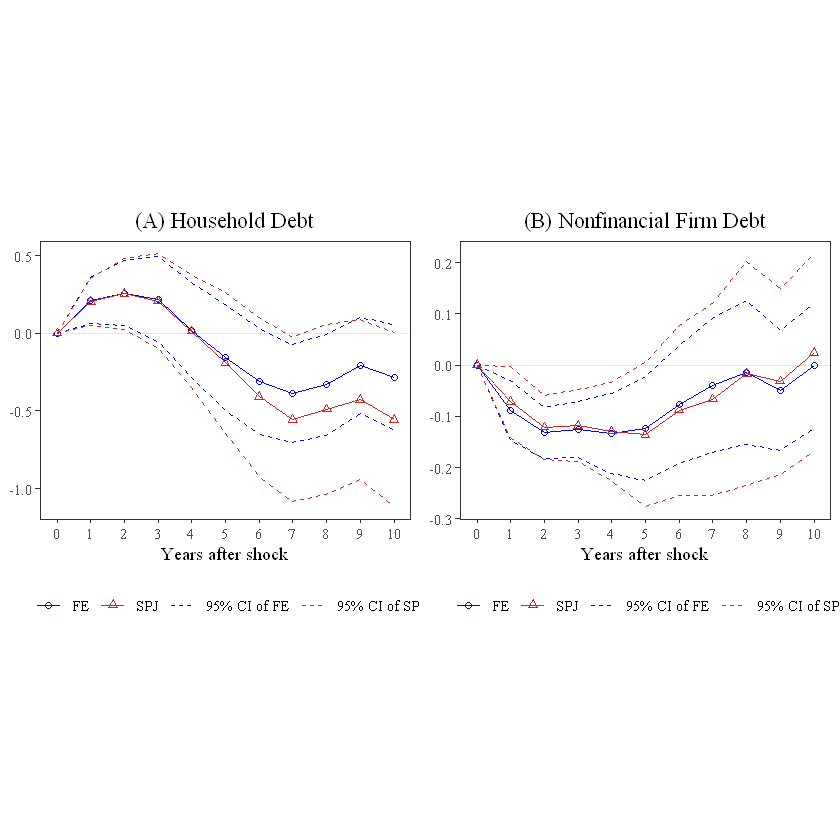

In [4]:
# =====================================================================
# 1. SETUP
# =====================================================================

# Clearing
rm(list=ls())
# This file is expected to define the function `LP_panel()`.
source("LP_panel_all.r")

# =====================================================================
# 2. DATA, MODEL SPECIFICATION, AND ESTIMATION
# =====================================================================

# Load the dataset.
data <- read.csv("empirical_MSV_f2.csv")

# Define the shock variable.
X.name = c("L0HHD_L1GDP","L0NFD_L1GDP")
# Define the control variables.
c.name = c("L0y","L1y","L2y","L3y","L4y",
           "L1HHD_L1GDP","L2HHD_L1GDP","L3HHD_L1GDP","L4HHD_L1GDP",
           "L1NFD_L1GDP","L2NFD_L1GDP","L3NFD_L1GDP","L4NFD_L1GDP")
# Define the outcome variables for each horizon.
Y.names <- c("F1y","F2y","F3y","F4y","F5y","F6y","F7y","F8y","F9y","F10y")

# Create empty matrices to store results for IRF and se.
IRF.FE <- rbind(0,matrix(NA,length(Y.names),2))
se.FE <- rbind(0,matrix(NA,length(Y.names),2))
IRF.jackknife <- rbind(0,matrix(NA,length(Y.names),2))
se.jackknife <- rbind(0,matrix(NA,length(Y.names),2))

# Loop through each outcome variable (horizon).
for (iname in 1:length(Y.names)){
  Y.name <- Y.names[iname]
  
  # Run FE estimation.
  fit.FE <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                     c.name = c.name,
                     lagY = 0, H=0, 
                     method = "FE",
                     te = F,
                     two_way_cluster = T,
                     robust = F,
                     eigens = F)
  # Store the FE results.
  IRF.FE[iname+1,] <-  fit.FE$IRF
  se.FE[iname+1,] <-  fit.FE$se
  
  # Run SPJ estimation.
  fit.jackknife <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                            c.name = c.name,
                            lagY = 0, H=0, 
                            method = "SPJ",
                            te = F,
                            two_way_cluster = T,
                            robust = F,
                            eigens = F)
  # Store the SPJ results.
  IRF.jackknife[iname+1,] <-  fit.jackknife$IRF
  se.jackknife[iname+1,] <-  fit.jackknife$se
}

# Calculate 95% confidence intervals for FE results.
low <- IRF.FE  - 1.96*se.FE 
high <- IRF.FE  + 1.96*se.FE 
plot.mat.FE <- cbind(low,IRF.FE,high)
plot.mat.FE[1,] <- 0 # No estimation required when h=0
# Calculate 95% confidence intervals for SPJ results.
low = IRF.jackknife - 1.96*se.jackknife
high = IRF.jackknife + 1.96*se.jackknife
plot.mat.jackknife <- cbind(low,IRF.jackknife,high)
plot.mat.jackknife[1,] <- 0  # No estimation required when h=0

# =====================================================================
# 3. PLOTTING
# =====================================================================

#Household
# Combine all results into a single data frame for plotting.
H=length(Y.names)
j_data = data.frame(cbind(0:H,plot.mat.FE[,c(3,1,5)],plot.mat.jackknife[,c(3,1,5)]))
colnames(j_data) <- c("h","fe","fe_l","fe_u","jackknife","jackknife_u","jackknife_l")
j_data <- melt(j_data,id="h")
fjg = substr(j_data$variable, 1, 2)
gr=c(rep("fe",11),rep("fc",22),rep("ja",11),rep("jc",22))
j_data <- cbind(j_data,fjg,gr)

# Plot with ggplot2.
hj = ggplot(j_data, aes(x=h, y=value, group=variable, color=gr, linetype=gr, shape=gr)) +
  geom_line() +
  geom_hline(aes(yintercept=0), colour="1", linetype="solid",alpha = 0.1) +
  scale_color_manual(values=c("blue","firebrick3", "blue","firebrick3"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  scale_linetype_manual(values=c("solid","solid","dashed","dashed"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  geom_point()+
  scale_shape_manual(values = c(21,24,NA,NA),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ"))+
  guides(color=guide_legend('title'),linetype=guide_legend('title'),shape=guide_legend('title'))+
  scale_x_continuous(breaks=j_data$h, labels = j_data$h) +
  labs(x = "Years after shock", y = NULL, title = "(A) Household Debt") +
  theme_bw() +
  theme(panel.grid=element_blank()) +
  theme(aspect.ratio=3/4,
        text=element_text(family="serif"),
        plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom")

# Firm
# Combine all results into a single data frame for plotting.
j_data = data.frame(cbind(0:H,plot.mat.FE[,c(4,2,6)],plot.mat.jackknife[,c(4,2,6)]))
colnames(j_data) <- c("h","fe","fe_l","fe_u","jackknife","jackknife_u","jackknife_l")
j_data <- melt(j_data,id="h")
fjg = substr(j_data$variable, 1, 2)
gr=c(rep("fe",11),rep("fc",22),rep("ja",11),rep("jc",22))
j_data <- cbind(j_data,fjg,gr)

# Plot with ggplot2.
fj = ggplot(j_data, aes(x=h, y=value, group=variable, color=gr, linetype=gr, shape=gr)) +
  geom_line() +
  geom_hline(aes(yintercept=0), colour="1", linetype="solid",alpha = 0.1) +
  scale_color_manual(values=c("blue","firebrick3", "blue","firebrick3"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  scale_linetype_manual(values=c("solid","solid","dashed","dashed"),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ")) +
  geom_point()+
  scale_shape_manual(values = c(21,24,NA,NA),breaks=c("fe","ja","fc","jc"),labels = c("FE", "SPJ","95% CI of FE","95% CI of SPJ"))+
  guides(color=guide_legend('title'),linetype=guide_legend('title'),shape=guide_legend('title'))+
  scale_x_continuous(breaks=j_data$h, labels = j_data$h) +
  labs(x = "Years after shock", y = NULL, title = "(B) Nonfinancial Firm Debt") +
  theme_bw() +
  theme(panel.grid=element_blank()) +
  theme(aspect.ratio=3/4,
        text=element_text(family="serif"),
        plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom")

# =====================================================================
# 4. EXPORTING THE FIGURE
# =====================================================================

# Combine the two plots into one figure and save it as a PDF.
msv = suppressWarnings(ggarrange(hj,fj, ncol=2,nrow=1, align = "hv"))
ggsave("MSV_f2.pdf", msv, width = 8, height = 4, units = 'in', dpi = 1200)
# Display the combined figure.
msv

## 4. Cerra and Saxena (2008)

This script replicates **Figure 7**. The analysis uses the dataset from the CS's official replication package.

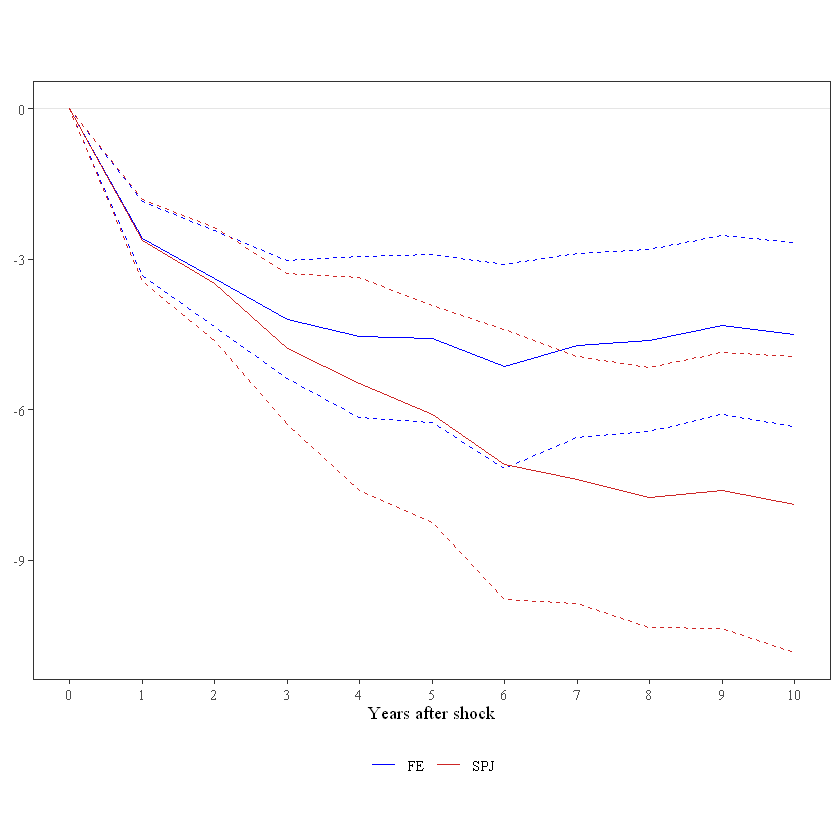

In [6]:
# =====================================================================
# 1. SETUP
# =====================================================================

# Clearing
rm(list=ls())
# This file is expected to define the function `LP_panel()`.
source("LP_panel_all.r")

# =====================================================================
# 2. DATA, MODEL SPECIFICATION, AND ESTIMATION
# =====================================================================

# Load the dataset.
data <- read.csv("empirical_CS_f3.csv")

# Define the shock variable.
X.name = c("CRISIS")
# Define the control variables.
c.name = c("l1CRISIS","l2CRISIS",	"l3CRISIS",	"l4CRISIS", "l1GRRT_WB","l2GRRT_WB","l3GRRT_WB","l4GRRT_WB")
# Define the outcome variables for each horizon.
Y.names <- c("cf1GRRT_WB",	"cf2GRRT_WB",	"cf3GRRT_WB",	"cf4GRRT_WB",	"cf5GRRT_WB",	"cf6GRRT_WB",	"cf7GRRT_WB",	"cf8GRRT_WB",	"cf9GRRT_WB",	"cf10GRRT_WB")

# Create empty matrices to store results for IRF and se.
IRF.FE <- rbind(0,matrix(NA,length(Y.names),length(X.name)))
se.FE <- rbind(0,matrix(NA,length(Y.names),length(X.name)))
IRF.jackknife <- rbind(0,matrix(NA,length(Y.names),length(X.name)))
se.jackknife <- rbind(0,matrix(NA,length(Y.names),length(X.name)))

# Loop through each outcome variable (horizon).
for (iname in 1:length(Y.names)){
  Y.name <- Y.names[iname]

  # Run FE estimation.
  fit.FE <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                     c.name = c.name,
                     lagY = 0, H=0, 
                     method = "FE",
                     te = F,
                     two_way_cluster = F,
                     robust = F,
                     eigens = F)
  # Store the FE results.
  IRF.FE[iname+1,] <-  fit.FE$IRF
  se.FE[iname+1,] <-  fit.FE$se
  
  # Run SPJ estimation.
  fit.jackknife <- LP_panel(data,Y.name = Y.name, X.name = X.name,
                     c.name = c.name,
                     lagY = 0, H=0, 
                     method = "SPJ",
                     te = F,
                     two_way_cluster = F,
                     robust = F,
                     eigens = F)
  # Store the SPJ results.
  IRF.jackknife[iname+1,] <-  fit.jackknife$IRF
  se.jackknife[iname+1,] <-  fit.jackknife$se
}

# Calculate 95% confidence intervals for FE results.
low <- IRF.FE  - 1.96*se.FE 
high <- IRF.FE  + 1.96*se.FE 
plot.mat.FE <- cbind(low,IRF.FE,high)
plot.mat.FE[1,] <- 0 # No estimation required when h=0
# Calculate 95% confidence intervals for SPJ results.
low = IRF.jackknife - 1.96*se.jackknife
high = IRF.jackknife + 1.96*se.jackknife
plot.mat.jackknife <- cbind(low,IRF.jackknife,high)
plot.mat.jackknife[1,] <- 0 # No estimation required when h=0

# =====================================================================
# 3. PLOTTING
# =====================================================================

# Combine all results into a single data frame for plotting.
H = length(Y.names)
j_data = data.frame(cbind(0:H,plot.mat.FE[,c(2,1,3)],plot.mat.jackknife[,c(2,1,3)]))
colnames(j_data) <- c("h","fe","fe_l","fe_u","jackknife","jackknife_u","jackknife_l")
j_data <- melt(j_data,id="h")
fjg = substr(j_data$variable, 1, 2)
j_data <- cbind(j_data,fjg)

# Plot with ggplot2.
cs=ggplot(j_data, aes(x=h, y=value, group=variable, color=fjg, linetype=variable)) +
  geom_line() +
  geom_hline(aes(yintercept=0), colour="1", linetype="solid",alpha = 0.1) +
  scale_color_manual(values=c("blue", "firebrick3"),labels = c("FE", "SPJ")) +
  scale_linetype_manual(values=c("solid","dashed","dashed","solid","dashed","dashed"),guide = "none") +
  scale_x_continuous(breaks=j_data$h, labels = j_data$h) +
  labs(x = "Years after shock", y = NULL, title = " ") +
  theme_bw() +
  theme(panel.grid=element_blank()) +
  theme(aspect.ratio=3/4,
        text=element_text(family="serif"),
        plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom")

# =====================================================================
# 4. EXPORTING THE FIGURE
# =====================================================================

# Save the plot as a PDF.
ggsave("CS_f3.pdf", cs, width = 4, height = 4, units = 'in', dpi = 1200)
# Display the combined figure.
cs